<a href="https://colab.research.google.com/github/niklasfaller/DIS21-BIg-Data/blob/main/Ex6_strategies_against_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200">

# 6th exercise: <font color="#C70039">Strategies against overfitting</font>
* Course: DIS21a.1
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook modifications and adaptations: Niklas Faller 11154696
* Date:   11.01.2024

<img src="https://docs.aws.amazon.com/machine-learning/latest/dg/images/mlconcepts_image5.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information about your tasks (e.g. regarding the set of certain paramaters or specific computational tricks, etc.), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation (for instance, after you have run through your test plan) you may use German language.
This applies to all exercises in DIS 21a.1.  

---------------------

### <font color="ce33ff">DESCRIPTION</font>:

Until now, in all the examples  (movie review sentiment prediction, topic classification, and house price regression)
we noticed that the model performance on the simple hold-out validation data always peaked after a few epochs and then started degrading, i.e. the model quickly started to _overfit_ to the training data. Overfitting happens in every single machine learning problem. Learning how to deal with overfitting is essential to mastering machine learning and becoming a good data scientist.

This notebook allows you for learning how you effectively can fight overfitting by preventing a model from learning misleading or irrelevant patterns found in the training data. As you have learned in my lecture already, the best solution is of course to get more training data. A model trained on more data will naturally generalize better. When that is not possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The process of fighting overfitting this way is called _regularization_. Let us review some of the most common regularization techniques and apply them in practice. For doing so, the IMDB movie classification model from the previous exercise is chosen again.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
Within this notebook, the tasks that you need to work on are always listed as bullet points below.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook before submitting it.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully.
    * for better understanding, add comments whereever you feel it necessary
    * run the notebook for the first time and note the result in a markdown table.
        * I have provided you with an example of a table in markdown (see below). Make sure you adapt your table accordingly.
        * Put the table at the end of the notebook.
        * This type of table will be needed in the other exercises as well. Always put it at the end.
    
| type of method | loss function | optimizer | accuracy |
| :-: | :-: | :-: | :-: |
| classification | categorical_crossentropy | bamm !|.666

4. in section 1 (Reducing the network's size) add your own code whereever it is indicated in the notebook and get it running.
5. add networks that are slightly bigger and smaller than the one that is optimal (i.e., in addition to the ones that are largely smaller or bigger).
    * visualize all their performance curves in the same two charts: the one for the acc and the one for the loss.
    * (`little hint`: since the batch_size and the no_of_epochs stays the same always, you should consider to build yourself a (ANN_build_compile_function) which you can instantiate everytime you want to build a new ANN of different size. Store the history object in a list and visualize them as indicated above.
    * use a table similar to the one from above to store the min_no_of_epochs for every model. You might consider to call a python function to compute the minimum rather than doing it visually.
    
6. write a test plan for testing the so-called dropout regularization. Start with dropout of 10% and then increase stepwise to end up with 90% and see what happens to the ANN. Store the values in the table (as the one from above) and try find the best dropout-rate.

-----------------------------------------------------------------------------------

## START OF THE NOTEBOOK CODE
----------------------------------------------------------------------------------------------------------------------
### necessary imports
others are going to be included as soon as they are needed

In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
import numpy as np
#tensorflow.keras.__version__

### loading and preparing the IMDB movie review data set
as done before

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

17464789/17464789 [==============================] - 0s 0us/step


### Fighting overfitting

#### 1. Reducing the network's size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power.

<font color="C70039">Always keep this in mind:</font> <font color="ce33ff">machine learning, and especially deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.</font>

However, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets, in other words, the type of representations that we data scientists are interested in.

<font color="C70039">NOTE:</font><font color="ce33ff">Always keep in mind that you should be using models that have enough parameters that they will not be underfitting: your model should not be starved for memorization resources. </font>
    
<font color="C70039">There is a compromise to be found between `too much capacity` and `not enough capacity`.</font>

Unfortunately, there is no magical formula to determine what the right number of layers is or what the right size for each layer is. A data scientist needs to evaluate an array of different architectures in order to find the right model size. The general workflow to find an appropriate model size is to start with relatively few layers and parameters and start increasing the size of the layers or adding new layers until diminishing returns with regard to the validation loss.

If you are interested to deepen this topic on how to compute the right size of training data, you should query the web for _learning curves_ such as the following:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/24/Learning_Curves_%28Naive_Bayes%29.png" style="float: center;" width="500">


However, let us try to determine the right size stepwise on the IMDB movie review classifications ANN, who's architecture was: (compare lecture slides)

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace that ANN of (16,16,1) with a smaller network of (4,4,1), as shown on lecture slides p.210.

In [4]:
smaller_model = models.Sequential()

smaller_model.add(layers.Dense(4, activation = 'relu', input_shape = (10000,)))
smaller_model.add(layers.Dense(4, activation = 'relu'))
smaller_model.add(layers.Dense(1, activation = 'sigmoid'))

smaller_model.compile(optimizer = 'rmsprop',
                       loss = 'binary_crossentropy',
                       metrics = ['acc'])


Now, let's compare the validation losses of the original network and the smaller network. The dots are the validation loss values of the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

In [5]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 99ms/step - loss: 0.4736 - acc: 0.8048 - val_loss: 0.3472 - val_acc: 0.8768
Epoch 2/20
49/49 [==============================] - 2s 41ms/step - loss: 0.2777 - acc: 0.9027 - val_loss: 0.2880 - val_acc: 0.8889
Epoch 3/20
49/49 [==============================] - 2s 41ms/step - loss: 0.2141 - acc: 0.9227 - val_loss: 0.2940 - val_acc: 0.8807
Epoch 4/20
49/49 [==============================] - 3s 57ms/step - loss: 0.1824 - acc: 0.9348 - val_loss: 0.2900 - val_acc: 0.8846
Epoch 5/20
49/49 [==============================] - 3s 51ms/step - loss: 0.1563 - acc: 0.9460 - val_loss: 0.3105 - val_acc: 0.8774
Epoch 6/20
49/49 [==============================] - 2s 41ms/step - loss: 0.1351 - acc: 0.9534 - val_loss: 0.3283 - val_acc: 0.8740
Epoch 7/20
49/49 [==============================] - 2s 38ms/step - loss: 0.1219 - acc: 0.9580 - val_loss: 0.3325 - val_acc: 0.8768
Epoch 8/20
49/49 [==============================] - 3s 54ms/step - loss: 0.1066 - a

In [6]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 117ms/step - loss: 0.4851 - acc: 0.8138 - val_loss: 0.3874 - val_acc: 0.8659
Epoch 2/20
49/49 [==============================] - 3s 52ms/step - loss: 0.3072 - acc: 0.8969 - val_loss: 0.3139 - val_acc: 0.8813
Epoch 3/20
49/49 [==============================] - 2s 38ms/step - loss: 0.2403 - acc: 0.9180 - val_loss: 0.2868 - val_acc: 0.8877
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2043 - acc: 0.9289 - val_loss: 0.2795 - val_acc: 0.8890
Epoch 5/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1803 - acc: 0.9382 - val_loss: 0.2812 - val_acc: 0.8871
Epoch 6/20
49/49 [==============================] - 3s 64ms/step - loss: 0.1614 - acc: 0.9455 - val_loss: 0.2867 - val_acc: 0.8864
Epoch 7/20
49/49 [==============================] - 3s 57ms/step - loss: 0.1475 - acc: 0.9503 - val_loss: 0.2997 - val_acc: 0.8818
Epoch 8/20
49/49 [==============================] - 2s 40ms/step - loss: 0.1345 - 

In [7]:
epochs = range(1, 21) # always add one
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

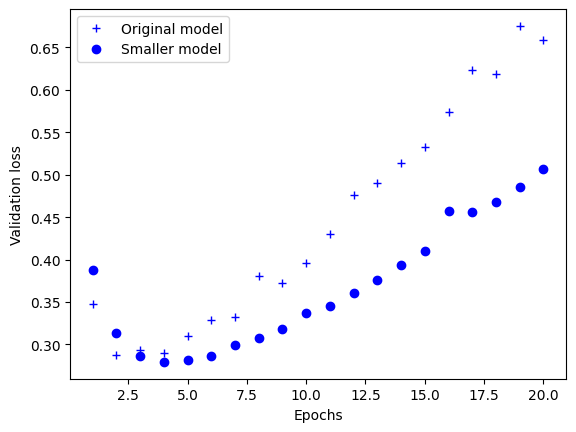

In [8]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

As you can see, the smaller network starts overfitting later than the reference one and its performance
degrades much more slowly once it starts overfitting.

Now, let's add to this benchmark a network that has much more capacity, far more than the problem would need (again see lectures slide p.210).

In [9]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [10]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 21s 422ms/step - loss: 0.4930 - acc: 0.7761 - val_loss: 0.5961 - val_acc: 0.7226
Epoch 2/20
49/49 [==============================] - 22s 455ms/step - loss: 0.2828 - acc: 0.8831 - val_loss: 0.2671 - val_acc: 0.8905
Epoch 3/20
49/49 [==============================] - 17s 342ms/step - loss: 0.2117 - acc: 0.9167 - val_loss: 0.2817 - val_acc: 0.8849
Epoch 4/20
49/49 [==============================] - 22s 463ms/step - loss: 0.1716 - acc: 0.9331 - val_loss: 0.3102 - val_acc: 0.8675
Epoch 5/20
49/49 [==============================] - 16s 333ms/step - loss: 0.1216 - acc: 0.9556 - val_loss: 0.3370 - val_acc: 0.8810
Epoch 6/20
49/49 [==============================] - 16s 337ms/step - loss: 0.0900 - acc: 0.9686 - val_loss: 0.3763 - val_acc: 0.8757
Epoch 7/20
49/49 [==============================] - 20s 417ms/step - loss: 0.0677 - acc: 0.9784 - val_loss: 0.3671 - val_acc: 0.8804
Epoch 8/20
49/49 [==============================] - 17s 353ms/step - 

Here's how the bigger ANN performes compared to the reference one. The dots are the validation loss values of the bigger network, and the crosses are the initial network.

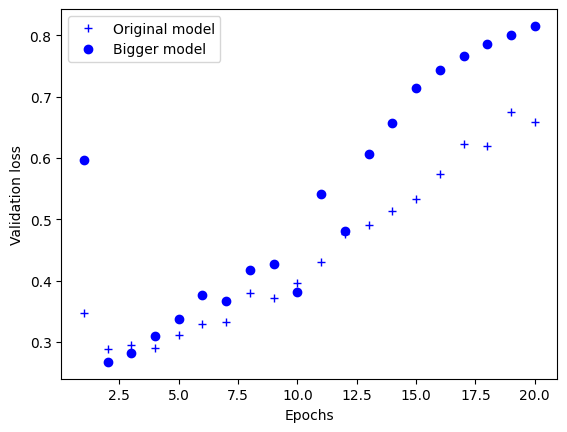

In [11]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away, after just one epoch and overfits much more severely. Its validation loss is also more noisy.

Meanwhile, here are the training losses for our two networks:

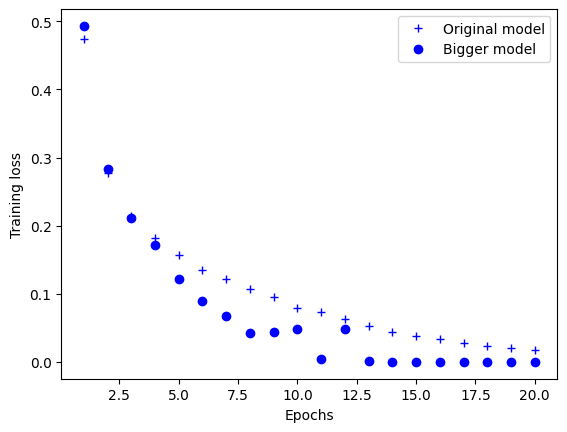

In [12]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large
difference between the training and validation loss).

### 2. Adding weight regularization

According to Occam's Razor, given some training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and simpler models are less likely to overfit than complex ones.

A `simple model` in this context is a model where the distribution of parameter values has got less entropy or a model with fewer parameters altogether, as seen in the first section above. Thus, a common way to fight overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a kind of _cost_ associated with having large weights. In the lecture you have learned two ways of regularization:

* L1 regularization, where the cost added is proportional to the _absolute value of the weight coefficients_ (i.e. to what is called the "L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weight coefficients_ (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. As often in machine learning, do not let the different names confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is quite easy by super simply passing _weight regularizer instances_ to layers as keyword arguments. Let us add L2 weight regularization to the ANN from above.

In [13]:
from tensorflow.keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of
the network. Note that because this penalty is _only added during training time_, the loss for this network will be much higher at training than at test time.

Here is the impact of our L2 regularization penalty:

In [15]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 98ms/step - loss: 0.5293 - acc: 0.8081 - val_loss: 0.4042 - val_acc: 0.8756
Epoch 2/20
49/49 [==============================] - 3s 52ms/step - loss: 0.3386 - acc: 0.8957 - val_loss: 0.3572 - val_acc: 0.8740
Epoch 3/20
49/49 [==============================] - 2s 40ms/step - loss: 0.2799 - acc: 0.9158 - val_loss: 0.3242 - val_acc: 0.8890
Epoch 4/20
49/49 [==============================] - 2s 41ms/step - loss: 0.2524 - acc: 0.9265 - val_loss: 0.3254 - val_acc: 0.8883
Epoch 5/20
49/49 [==============================] - 2s 38ms/step - loss: 0.2385 - acc: 0.9320 - val_loss: 0.3429 - val_acc: 0.8810
Epoch 6/20
49/49 [==============================] - 2s 40ms/step - loss: 0.2261 - acc: 0.9353 - val_loss: 0.3408 - val_acc: 0.8818
Epoch 7/20
49/49 [==============================] - 3s 55ms/step - loss: 0.2171 - acc: 0.9396 - val_loss: 0.3697 - val_acc: 0.8726
Epoch 8/20
49/49 [==============================] - 3s 54ms/step - loss: 0.2138 - a

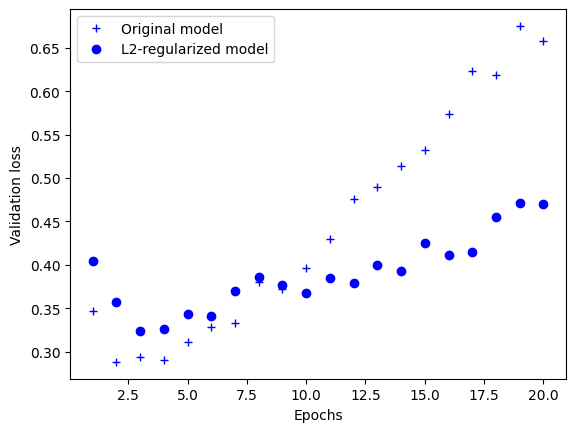

In [16]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses),
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [17]:
from tensorflow.keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

### 3. Adding dropout

Dropout is one of the most effective and most commonly used regularization technique for neural networks, developed by Hinton and team. Dropout, applied to a layer, consists of randomly "dropping out" (which simply means 'setting to zero') a number of
output features of the layer during training.

The "dropout rate" is the fraction of the features that are being zero'ed-out; it is usually set between 0.2 and 0.5.

In Keras, dropout can be added via the so-called `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

model.add(layers.Dropout(0.5))

Let us add two `Dropout` layers in our IMDB network to see how effective they are for reducing overfitting.

In [18]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [19]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 67ms/step - loss: 0.6030 - acc: 0.6707 - val_loss: 0.4617 - val_acc: 0.8605
Epoch 2/20
49/49 [==============================] - 2s 41ms/step - loss: 0.4636 - acc: 0.7974 - val_loss: 0.3584 - val_acc: 0.8788
Epoch 3/20
49/49 [==============================] - 3s 53ms/step - loss: 0.3804 - acc: 0.8490 - val_loss: 0.3037 - val_acc: 0.8884
Epoch 4/20
49/49 [==============================] - 3s 54ms/step - loss: 0.3307 - acc: 0.8756 - val_loss: 0.2818 - val_acc: 0.8901
Epoch 5/20
49/49 [==============================] - 2s 41ms/step - loss: 0.2872 - acc: 0.8978 - val_loss: 0.2930 - val_acc: 0.8841
Epoch 6/20
49/49 [==============================] - 2s 42ms/step - loss: 0.2604 - acc: 0.9115 - val_loss: 0.2912 - val_acc: 0.8861
Epoch 7/20
49/49 [==============================] - 2s 41ms/step - loss: 0.2366 - acc: 0.9210 - val_loss: 0.2913 - val_acc: 0.8883
Epoch 8/20
49/49 [==============================] - 2s 42ms/step - loss: 0.2155 - a

Let's plot the results:

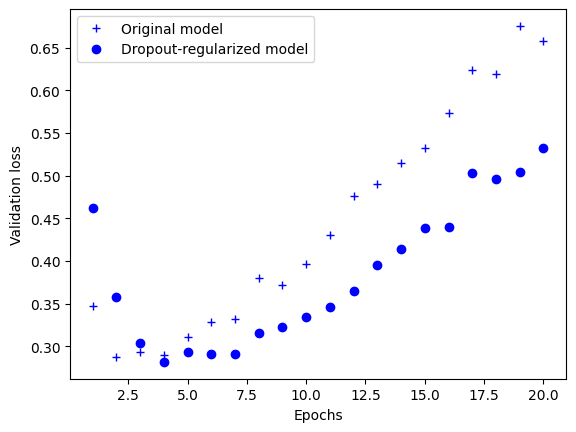

In [20]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### <font color="#C70039">Include your dropout result table here and reflect a good test plan (see task list)</font>

5. add networks that are slightly bigger and smaller than the one that is optimal (i.e., in addition to the ones that are largely smaller or bigger).
    * visualize all their performance curves in the same two charts: the one for the acc and the one for the loss.
    * (`little hint`: since the batch_size and the no_of_epochs stays the same always, you should consider to build yourself a (ANN_build_compile_function) which you can instantiate everytime you want to build a new ANN of different size. Store the history object in a list and visualize them as indicated above.
    * use a table similar to the one from above to store the min_no_of_epochs for every model. You might consider to call a python function to compute the minimum rather than doing it visually.

In [21]:
def get_model(size):
    model = models.Sequential()

    model.add(layers.Dense(size, activation = 'relu', input_shape = (10000,)))
    model.add(layers.Dense(size, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])

    return model

In [22]:
def get_minimal_loss(hist_list, model_type):
  print(hist_list)
  values = []
  idx = []
  for i, val in enumerate(hist_list):
    if not values:
      values.append(val)
      idx.append(i)
    elif val < values[-1]:
      values.append(val)
      idx.append(i)
    elif val > values[-1]:
      print(f"listtype: {model_type} //", f" index: {idx[-1]} //",  f" epoch: {idx[-1] + 1} //", f"value: {values[-1]}")
      break

In [23]:
slightly_smaller_model = get_model(8)

slightly_smaller_model_hist = slightly_smaller_model.fit(x_train, y_train,
                                     epochs = 20,
                                     batch_size = 512,
                                     validation_data = (x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 78ms/step - loss: 0.4743 - acc: 0.8081 - val_loss: 0.3578 - val_acc: 0.8770
Epoch 2/20
49/49 [==============================] - 2s 40ms/step - loss: 0.2792 - acc: 0.9064 - val_loss: 0.2907 - val_acc: 0.8885
Epoch 3/20
49/49 [==============================] - 2s 37ms/step - loss: 0.2149 - acc: 0.9251 - val_loss: 0.2856 - val_acc: 0.8854
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1807 - acc: 0.9366 - val_loss: 0.3013 - val_acc: 0.8798
Epoch 5/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1596 - acc: 0.9457 - val_loss: 0.2973 - val_acc: 0.8815
Epoch 6/20
49/49 [==============================] - 3s 62ms/step - loss: 0.1408 - acc: 0.9531 - val_loss: 0.3154 - val_acc: 0.8778
Epoch 7/20
49/49 [==============================] - 2s 44ms/step - loss: 0.1282 - acc: 0.9575 - val_loss: 0.3260 - val_acc: 0.8772
Epoch 8/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1145 - a

In [24]:
slightly_bigger_model = get_model(32)

slightly_bigger_model_hist = slightly_bigger_model.fit(x_train, y_train,
                                     epochs = 20,
                                     batch_size = 512,
                                     validation_data = (x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 88ms/step - loss: 0.4434 - acc: 0.8034 - val_loss: 0.3167 - val_acc: 0.8803
Epoch 2/20
49/49 [==============================] - 3s 63ms/step - loss: 0.2642 - acc: 0.9000 - val_loss: 0.2892 - val_acc: 0.8846
Epoch 3/20
49/49 [==============================] - 4s 74ms/step - loss: 0.2074 - acc: 0.9226 - val_loss: 0.2857 - val_acc: 0.8837
Epoch 4/20
49/49 [==============================] - 3s 61ms/step - loss: 0.1750 - acc: 0.9366 - val_loss: 0.3424 - val_acc: 0.8659
Epoch 5/20
49/49 [==============================] - 2s 49ms/step - loss: 0.1528 - acc: 0.9437 - val_loss: 0.3994 - val_acc: 0.8571
Epoch 6/20
49/49 [==============================] - 3s 51ms/step - loss: 0.1365 - acc: 0.9506 - val_loss: 0.3570 - val_acc: 0.8721
Epoch 7/20
49/49 [==============================] - 3s 70ms/step - loss: 0.1172 - acc: 0.9586 - val_loss: 0.3616 - val_acc: 0.8709
Epoch 8/20
49/49 [==============================] - 3s 66ms/step - loss: 0.1072 - a

[0.35783612728118896, 0.29067322611808777, 0.28559985756874084, 0.3012886345386505, 0.29734766483306885, 0.31541672348976135, 0.3260219991207123, 0.36125367879867554, 0.36166343092918396, 0.3801281154155731, 0.40828046202659607, 0.42132753133773804, 0.4484272599220276, 0.4752158522605896, 0.4903084337711334, 0.5212191939353943, 0.5365541577339172, 0.5653517842292786, 0.591862678527832, 0.671963095664978]
listtype: Slightly_small //  index: 2 //  epoch: 3 // value: 0.28559985756874084
[0.31669241189956665, 0.28922778367996216, 0.28568434715270996, 0.34236663579940796, 0.3994245231151581, 0.35702118277549744, 0.3616035282611847, 0.37582722306251526, 0.44173187017440796, 0.42649245262145996, 0.45678019523620605, 0.49634620547294617, 0.5118006467819214, 0.5437151789665222, 0.697793185710907, 0.5960711240768433, 0.6253718137741089, 0.6532796621322632, 0.6835344433784485, 0.708252489566803]
listtype: Slightly_big //  index: 2 //  epoch: 3 // value: 0.28568434715270996
[0.3472445011138916, 0.

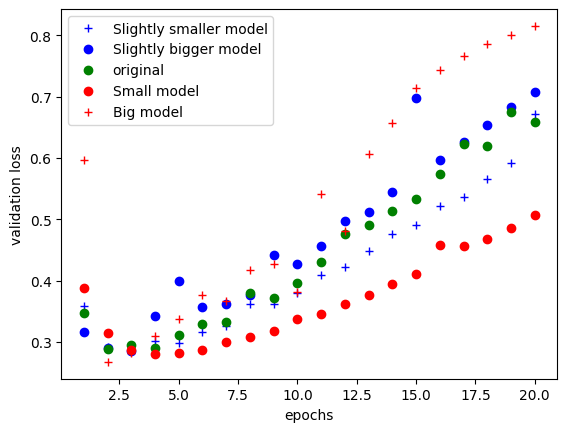

In [25]:
slightly_smaller_loss = slightly_smaller_model_hist.history['val_loss']
slightly_bigger_loss = slightly_bigger_model_hist.history['val_loss']

get_minimal_loss(slightly_smaller_loss, 'Slightly_small')
get_minimal_loss(slightly_bigger_loss, 'Slightly_big')
get_minimal_loss(original_val_loss, 'Original')
get_minimal_loss(smaller_model_val_loss, 'Small')
get_minimal_loss(bigger_model_val_loss, 'Big')

import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, slightly_smaller_loss, 'b+', label = 'Slightly smaller model')

# "bo" is for "blue dot"
plt.plot(epochs, slightly_bigger_loss, 'bo', label = 'Slightly bigger model')

# "gr" is for "green cross"
plt.plot(epochs, original_val_loss, 'go', label = 'original')

# "ro" is for "red dot"
plt.plot(epochs, smaller_model_val_loss , 'ro', label = 'Small model')

# "bo" is for "blue dot"
plt.plot(epochs, bigger_model_val_loss, 'r+', label = 'Big model')

plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.legend()

plt.show()

In [26]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
dpt_model.add(layers.Dropout(0.9))
dpt_model.add(layers.Dense(16, activation = 'relu'))
dpt_model.add(layers.Dropout(0.9))
dpt_model.add(layers.Dense(1, activation = 'sigmoid'))

dpt_model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])

In [27]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs = 20,
                               batch_size = 512,
                               validation_data = (x_test, y_test))

Epoch 1/20
49/49 [==============================] - 5s 95ms/step - loss: 0.6998 - acc: 0.5042 - val_loss: 0.6930 - val_acc: 0.4896
Epoch 2/20
49/49 [==============================] - 2s 40ms/step - loss: 0.6935 - acc: 0.5015 - val_loss: 0.6923 - val_acc: 0.4925
Epoch 3/20
49/49 [==============================] - 2s 40ms/step - loss: 0.6943 - acc: 0.4978 - val_loss: 0.6929 - val_acc: 0.5109
Epoch 4/20
49/49 [==============================] - 2s 41ms/step - loss: 0.6931 - acc: 0.5016 - val_loss: 0.6925 - val_acc: 0.5295
Epoch 5/20
49/49 [==============================] - 2s 41ms/step - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6916 - val_acc: 0.5442
Epoch 6/20
49/49 [==============================] - 3s 54ms/step - loss: 0.6938 - acc: 0.4996 - val_loss: 0.6911 - val_acc: 0.5450
Epoch 7/20
49/49 [==============================] - 3s 67ms/step - loss: 0.6945 - acc: 0.5012 - val_loss: 0.6909 - val_acc: 0.5583
Epoch 8/20
49/49 [==============================] - 2s 40ms/step - loss: 0.6930 - a

In [ ]:
results = dpt_model.evaluate(x_test, y_test)